# Exploratory Data Analysis

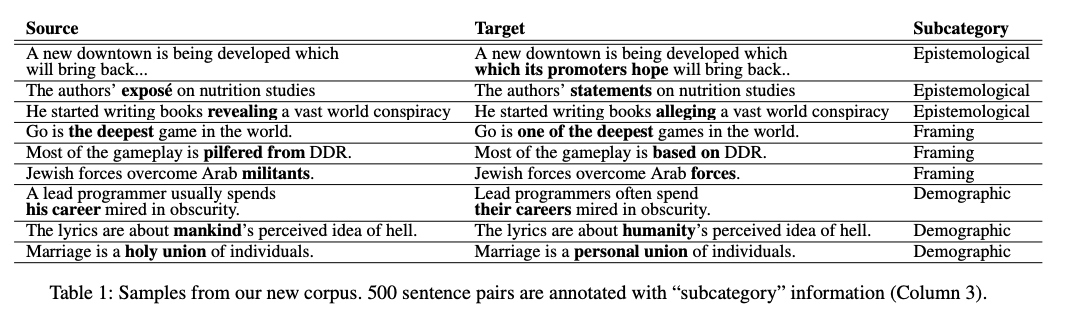

This notebook works through data collection, curation, conversion to HuggingFace Dataset object, and initial data exploration.

We will be working with the [Wiki Neutrality Corpus (WNC)](https://arxiv.org/pdf/1911.09709.pdf) - a parallel corpus of 180,000 biased and neutralized sentence pairs along with contextual sentences and metadata. The corpus was harvested from Wikipedia edits that were designed to ensure texts had a neutral point of view. WNC is the first parallel corpus of biased language.

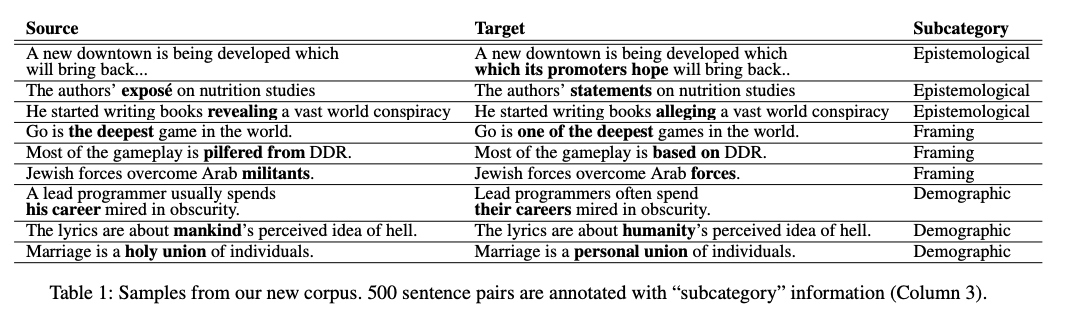

The Wiki Neutrality Corpus consists of aligned sentences pre and post-neutralization by English Wikipedia editors (Table 1). We used regular expressions to crawl 423,823 Wikipedia revisions between 2004 and 2019 where editors provided neutral point of view (NPOV)-related justification.

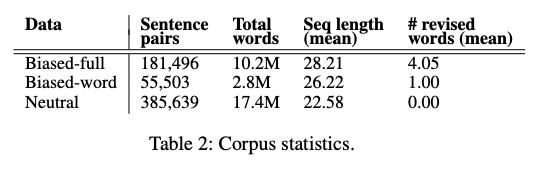

## Download Data

In [4]:
!mkdir -p ~/data/raw
!curl -L http://nlp.stanford.edu/projects/bias/bias_data.zip -o ~/data/raw/bias_data.zip
!unzip ~/data/raw/bias_data.zip -d ~/data/raw/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0   318    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  104M  100  104M    0     0  51.5M      0  0:00:02  0:00:02 --:--:-- 52.0M


## Inspect Data

In [1]:
from tqdm import tqdm

In [2]:
DATA_PATH = "/home/cdsw/data/raw/bias_data/WNC/biased.word.dev"

collect = []

for i, line in enumerate(tqdm(open(DATA_PATH))):
    parts = line.strip().split("\t")
    collect.append(parts)
    if i == 5:
        break

for rev in collect:
    print("REV_ID: ", rev[0])
    print()
    print("PRE-TOKEN: ", rev[1])
    print("POST-TOKEN: ", rev[2])
    print()
    print("PRE: ", rev[3])
    print("POST: ", rev[4])
    print()
    print()
    print("POS: ", rev[5])
    print("RELATIONS: ", rev[6])
    print(
        "------------------------------------------------------------------------------------------"
    )

5it [00:00, 858.15it/s]

REV_ID:  3257810

PRE-TOKEN:  in addition to sponsoring palestinian terror attacks against israel ( often through jordanian territory , much to king hussein ' s cha ##grin ) , syria also began shell ##ing of israeli civilian communities in north - eastern galilee , from gun em ##pl ##ace ##ments on the syrian - controlled go ##lan heights .
POST-TOKEN:  in addition to sponsoring palestinian attacks against israel ( often through jordanian territory , much to king hussein ' s cha ##grin ) , syria also began shell ##ing of israeli civilian communities in north - eastern galilee , from gun em ##pl ##ace ##ments on the syrian - controlled go ##lan heights .

PRE:  in addition to sponsoring palestinian terror attacks against israel (often through jordanian territory, much to king hussein's chagrin), syria also began shelling of israeli civilian communities in north-eastern galilee, from gun emplacements on the syrian-controlled golan heights.
POST:  in addition to sponsoring palestinian att

## Let's Inspect a Pre-built seq2seq Dataset

In [3]:
from datasets import load_dataset

In [4]:
raw_datasets = load_dataset("kde4", lang1="en", lang2="fr")

Using custom data configuration en-fr-lang1=en,lang2=fr
Reusing dataset kde4 (/home/cdsw/.cache/huggingface/datasets/kde4/en-fr-lang1=en,lang2=fr/0.0.0/243129fb2398d5b0b4f7f6831ab27ad84774b7ce374cf10f60f6e1ff331648ac)


  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
raw_datasets['train'].features

{'id': Value(dtype='string', id=None),
 'translation': Translation(languages=['en', 'fr'], id=None)}

In [6]:
raw_datasets['train'].description

'A parallel corpus of KDE4 localization files (v.2).\n\n92 languages, 4,099 bitexts\ntotal number of files: 75,535\ntotal number of tokens: 60.75M\ntotal number of sentence fragments: 8.89M\n'

In [7]:
raw_datasets['train'].features

{'id': Value(dtype='string', id=None),
 'translation': Translation(languages=['en', 'fr'], id=None)}

In [8]:
raw_datasets['train'][17]['translation']

{'en': 'Not all languages are available from the Babelfish service.',
 'fr': 'Toutes les langues ne sont pas disponibles à partir du service Babelfish.'}

In [9]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 210173
    })
})

In [10]:
raw_datasets["train"][18]

{'id': '18',
 'translation': {'en': "Machine translation is not a perfect science! Babelfish will at best give you a rough translation, and at worst will give you a very funny read. Do n't base important decisions on things you have read from a Babelfish translated page, without confirming that the translation is indeed accurate.",
  'fr': "La traduction automatique n'est pas une science parfaite & #160;! Babelfish vous donneras au mieux une traduction approximative et au pire un texte très drôle à lire. Ne basez pas vos décisions importantes sur des choses que vous avez lu à partir d'une page traduite par Babelfish sans avoir la confirmation que la traduction est effectivement précise."}}

## Format WNC Biased-word Data as HuggingFace Dataset

We'll start by working with the smaller "Biased-word" dataset used in the reference paper. Let's prepare the dataset by formatting it as a HuggingFace DatasetDict object.

In [11]:
%load_ext lab_black

In [12]:
import os
import torch
from collections import defaultdict
from datasets import load_dataset, Dataset, DatasetDict, Value, Translation, Features


def build_hf_dataset(path: str, one_word=True) -> DatasetDict:
    """
    Formats the raw biased-word data into HuggingFace DatasetDict object.

    Provided a path to the raw Wiki Neutrality Corpus (WNC) data files, this function parses
    each of the dev, test, and train sets and formats them as a HuggingFace DatasetDict object
    in the seq2seq style (i.e. ready for translation tasks).

    https://arxiv.org/pdf/1911.09709.pdf

    Args:
        path (str): path to directory containing raw WNC data files
        one_word (str): prepare one word edit version or full version of dataset

    Returns:
        DatasetDict

    """

    if one_word:
        splits = ["dev", "test", "train"]
        base_path = "biased.word."
    else:
        splits = ["full"]
        base_path = "biased."

    dataset_dict = defaultdict(dict)

    FEATURES = Features(
        {
            "rev_id": Value("string"),
            "translation": Translation(languages=["pre", "post"]),
        }
    )

    for split in splits:

        PATH = os.path.join(path, base_path + split)

        rev_ids = []
        translation_pairs = []

        for i, line in enumerate(tqdm(open(PATH))):
            parts = line.strip().split("\t")

            # note some entries contain the POS and REL fields, others dont
            if len(parts) == 7:
                rev_id, pre_tok, post_tok, pre_raw, post_raw, pos, rels = parts

            elif len(parts) == 5:
                rev_id, pre_tok, post_tok, pre_raw, post_raw = parts

            else:
                print(f"Skipped entry: {i}")

            rev_ids.append(rev_id)
            translation_pairs.append({"pre": pre_raw, "post": post_raw})

        split_dict = {
            "rev_id": rev_ids,
            "translation": translation_pairs,
        }

        dataset_dict[split] = Dataset.from_dict(split_dict, features=FEATURES)

    return DatasetDict(dataset_dict)

In [13]:
DATA_PATH = "/home/cdsw/data/raw/bias_data/WNC"

wnc_datasets = build_hf_dataset(DATA_PATH)

700it [00:00, 49457.80it/s]
1000it [00:00, 43513.89it/s]
53803it [00:00, 68842.25it/s]


In [14]:
wnc_datasets

DatasetDict({
    dev: Dataset({
        features: ['rev_id', 'translation'],
        num_rows: 700
    })
    test: Dataset({
        features: ['rev_id', 'translation'],
        num_rows: 1000
    })
    train: Dataset({
        features: ['rev_id', 'translation'],
        num_rows: 53803
    })
})

## EDA on WNC Biased-Word Datasets

**EDA Agenda:**
1. Manually inspect records to understand data and patterns
2. Check for duplicates within and across dataset splits
3. Calculate descriptive statistics on each dataset split
4. Analyze revision diffs - what words were commonly deleted or replaced.


### 1. Manually inspect & analyze some random samples

In [15]:
random_sample = wnc_datasets["train"].shuffle(seed=42).select(range(25))

In [16]:
import pandas as pd


def inspect_df(wnc_dataset_df: pd.DataFrame):

    for rev_id in set(wnc_dataset_df["rev_id"]):
        print(rev_id)
        print()
        temp_df = wnc_dataset_df[
            wnc_dataset_df.rev_id == str(rev_id)
        ]  ## this is for duplicate inspection later on
        for i, row in temp_df.iterrows():
            print(i)
            print(row["translation"]["pre"])
            print(row["translation"]["post"])
            print()

        print("-------------------------------")
        print()

**Observations:**
- Many of these examples do indeed reduce subjectivity: 856833678, 854195033, 879288389, 86379285, 255371998, 464589189
  - It seems these examples largely focus on changing or removing an adjective/adverb to "tone it down a bit"... which could likely be accomplished with some sophisticated rules and lexicon curations..
 
- Some of these seem non-NPOV related, meaning the dataset creators may not have high precision on isolating NPOV only edits: 823894954, 


In [17]:
inspect_df(random_sample.to_pandas())

169899659

3
its adherents are christians who accept the hebrew text of genesis is a literal account that god created the earth in six 24-hour days, or believe that existing evidence in the natural world today supports a strict interpretation of scriptural creation as historical fact, or that the scientific evidence supporting darwinian evolution, geological uniformitarianism, and other theories which are at odds with a literal interpretation of the genesis creation account, are either flawed or misinterpreted.
its adherents are christians who believe that the hebrew text of genesis is a literal account that god created the earth in six 24-hour days, or believe that existing evidence in the natural world today supports a strict interpretation of scriptural creation as historical fact, or that the scientific evidence supporting darwinian evolution, geological uniformitarianism, and other theories which are at odds with a literal interpretation of the genesis creation account, are either

### 2. Check for duplicates in and across dataset splits

In [15]:
from functools import reduce
from operator import concat

#### a. Duplicate `rev_id`'s?

In [144]:
rev_ids = reduce(
    concat, [wnc_datasets[split]["rev_id"] for split in wnc_datasets.keys()]
)

print(f"Looks like there are {len(rev_ids) - len(set(rev_ids))} duplicates")

Looks like there are 6 duplicates


In [136]:
%%time

duplicate_revids = set([rev_id for rev_id in rev_ids if rev_ids.count(rev_id) > 1])

CPU times: user 1min 40s, sys: 17.1 ms, total: 1min 40s
Wall time: 1min 40s


In [28]:
duplicate_dataset = wnc_datasets.filter(lambda x: x["rev_id"] in duplicate_revids)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/54 [00:00<?, ?ba/s]

**Looks like all the duplicates are in the train set**

In [29]:
duplicate_dataset["train"].to_pandas().sort_values("rev_id")

,rev_id,translation
2,170782428,{'post': 'to complete the lineup on their firs...
11,170782428,{'post': 'full of the brothers' pop culture ob...
1,232695029,{'post': 'the armstrongs and fine served jail ...
5,232695029,{'post': 'investigators believe that four peop...
0,241894774,"{'post': 'in addition, they all famously wear ..."
8,241894774,{'post': 'they also report abstaing from alcoh...
6,243772559,{'post': 'pettitte ended up getting the victor...
10,243772559,"{'post': 'he recorded his 2, 000th career stri..."
3,649752518,{'post': 'madeleine buckingham has served as c...
4,649752518,{'post': 'mother jones (abbreviated mojo) is a...


In [30]:
duplicates_df = duplicate_dataset["train"].to_pandas()

inspect_df(duplicates_df)

232695029

1
the armstrongs and fine served jail time, a combined total of only 12 years, and were subsequently paroled.
the armstrongs and fine served jail time, a combined total of 12 years, and were subsequently paroled.

5
investigators believe that four people were involved in the bombing: brothers karl armstrong and dwight armstrong, and accomplices david fine and leo burt.
investigators believe that four people were involved in the bombing: brothers karleton armstrong and dwight armstrong, and accomplices david fine and leo burt.

-------------------------------

170782428

2
to complete the lineup on their first full-length album, born innocent, they assembled a revolving door of talented musicians including a young john stielow on the drums.
to complete the lineup on their first full-length album, born innocent, they assembled a revolving door of musicians including a young john stielow on the drums.

11
full of the brothers' pop culture obsessions, born innocent featured odes

**Observations:**
- There appears to be no actual duplication of content here, other than just the revision ID's themselves.
- However, some of these examples do appear to have corrections that are non-NPOV related. For example, 232695029 - 5 introduces a spelling correction in a persons name. Or 243772559 - 10 that has a grammer correction.

**Action:**
- Let's just drop all of these examples from consideration as there are relatively few - right?

#### b. Duplicate `translation`'s?

In [31]:
translations = reduce(
    concat, [wnc_datasets[split]["translation"] for split in wnc_datasets.keys()]
)
translations = [
    tuple(translation.items()) for translation in translations
]  # make tuples so hashable

print(f"Looks like there are {len(translations) - len(set(translations))} duplicates")

Looks like there are 0 duplicates


### 3. Descriptive statistics on pre/post text across splits

In [32]:
import seaborn as sns

sns.set_theme()

#### a. Distribution of text by number of words

In [33]:
# create new dataset with calculated column lengths
wnc_data_mod = wnc_datasets.map(
    lambda example: {
        "length_pre": len(example["translation"]["pre"].split()),
        "length_post": len(example["translation"]["post"].split()),
    }
)

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

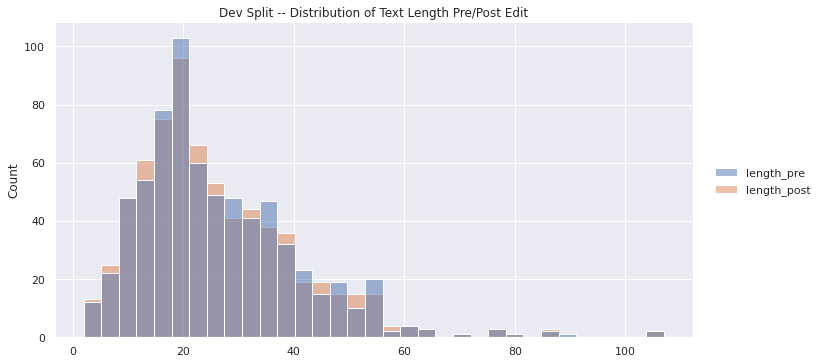

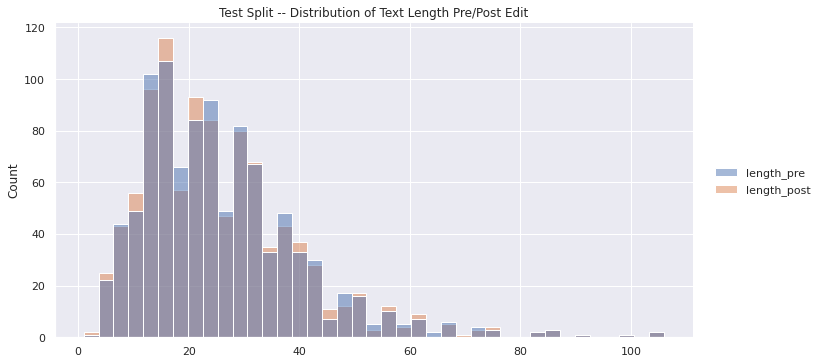

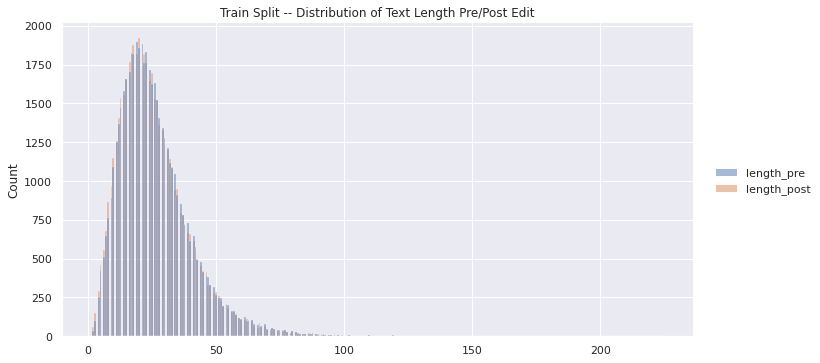

In [34]:
for split in wnc_data_mod.keys():
    test_df = wnc_data_mod[split].to_pandas()
    sns.displot(test_df[["length_pre", "length_post"]], kind="hist", aspect=2).set(
        title=f"{split.capitalize()} Split -- Distribution of Text Length Pre/Post Edit"
    )

In [35]:
# collect descriptive statistics for each split
stats = {}
for split in wnc_data_mod.keys():
    test_df = wnc_data_mod[split].to_pandas()
    stat = test_df[["length_pre", "length_post"]].describe().round(2)
    stats[split] = stat

# format as dataframe
pd.concat(stats).unstack(0).swaplevel(0, 1, axis=1).sort_index(axis=1)

dev                   test                  train           
      length_post length_pre length_post length_pre length_post length_pre
count      700.00     700.00     1000.00    1000.00    53803.00   53803.00
mean        26.07      26.32       25.70      25.97       26.08      26.38
std         14.62      14.54       14.65      14.62       14.55      14.51
min          2.00       2.00        1.00       2.00        1.00       2.00
25%         16.00      16.00       15.00      16.00       16.00      16.00
50%         23.00      23.00       23.00      23.00       23.00      24.00
75%         34.00      34.00       33.00      33.00       33.00      33.00
max        107.00     107.00      105.00     106.00      225.00     225.00

**Observations:**
- Distribution of text length across splits (dev, test, train) is very similar, even with drastically different sample sizes -- which is good
- Mean text length decreases after revision edits -- which suggests many of these edits are subtractive in nature
- Statistics are consistent with whats reported in the paper
- Min / Max sentence length could pose a concern

**Actions:**
- How long of an input can BERT take?
- Might need to remove outliers: above 100 words and below 3 words?

In [36]:
# really long texts
long = wnc_data_mod.filter(lambda example: example["length_pre"] > 100)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/54 [00:00<?, ?ba/s]

In [37]:
long["train"][1]

{'rev_id': '314415316',
 'translation': {'post': 'the faculties of arts (which is merging with the atkinson faculty of liberal & professional studies to form the faculty of liberal arts and professional studies in july 2009), science & engineering, liberal & professional studies (atkinson), and glendon college, for instance, each house separate mathematics departments, although some of these are being merged; the schulich school of business offers undergraduate and graduate international business administration programmes, but the atkinson faculty of liberal and professional studies\' school of administrative studies acts as a completely separate business school, nevertheless both atkinson and schulich share many full time professors any many of atkinson accounting courses "shadow" those of their schulich counterpart.',
  'pre': 'the faculties of arts (which is merging with the atkinson faculty of liberal & professional studies to form the faculty of liberal arts and professional studi

In [38]:
# really short texts
short = wnc_data_mod.filter(lambda example: example["length_pre"] < 4)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/54 [00:00<?, ?ba/s]

In [39]:
short["test"][0]

{'rev_id': '140577571',
 'translation': {'post': 'jehovah)', 'pre': 'our jehovah)'},
 'length_pre': 2,
 'length_post': 1}

In [40]:
short["train"][0]

{'rev_id': '206320755',
 'translation': {'post': 'evidence-based practice',
  'pre': 'evidence-based practice debate'},
 'length_pre': 3,
 'length_post': 2}

In [41]:
short["train"][90]

{'rev_id': '157063815',
 'translation': {'post': "cameraman's testimony", 'pre': "cameraman's story"},
 'length_pre': 2,
 'length_post': 2}

#### b. Distribution of text by change in number of words

aka - what proportion of edits were additive, subtractive, or net-even (by split)... aka did the edit introduce more words?

In [42]:
# calculate the change in text length after making revision
wnc_data_mod = wnc_data_mod.map(
    lambda example: {"delta": example["length_post"] - example["length_pre"]}
)

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

In [43]:
# aggregate number of revision by the change in length
deltas = {}
for split in wnc_data_mod.keys():
    delta = (
        wnc_data_mod[split].to_pandas()[["rev_id", "delta"]].groupby("delta").count()
    )
    deltas[split] = delta

# format for plotting
delta_df = pd.concat(deltas).unstack(0).droplevel(0, axis=1).fillna(0)

for col in delta_df.columns:
    delta_df[col] = delta_df[col] / delta_df[col].sum()

<AxesSubplot:title={'center':'Percentage of Edits by Change in Word Count (by Split)'}, xlabel='delta'>

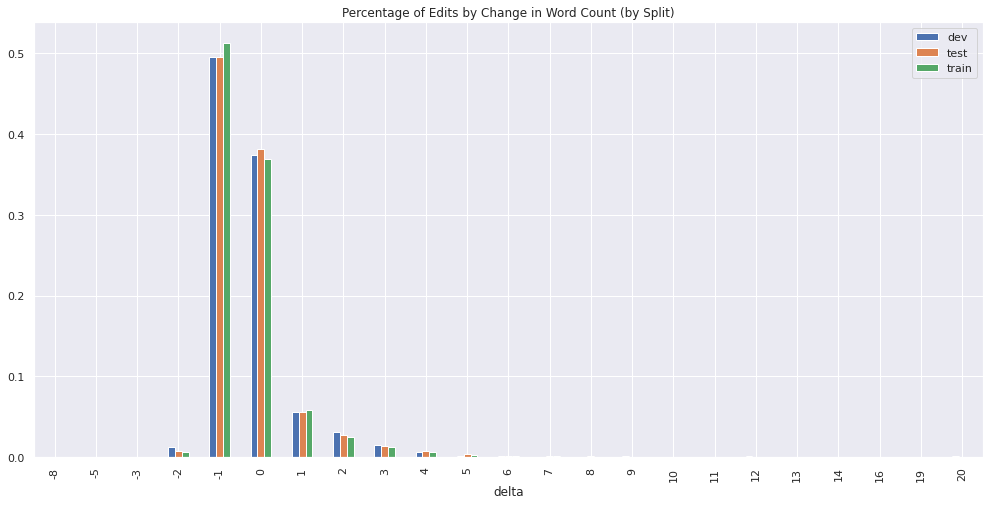

In [44]:
delta_df.plot.bar(
    title="Percentage of Edits by Change in Word Count (by Split)", figsize=(17, 8)
)

**Observations:**
- The vast majority of edits (~50%) removed 1 word from the original. This indicates most edits are subtractive in nature, which backs up the manual observation I had where it seems like subjective adjectives/adverbs are simply being dropped to lighten the tone.
    - This suggests that rather than actually "generating new text", you could simply build a model to predict if a given word (likely adjective/adverb) in the sentence is "subjective" and then simply remove it and achieve ~50% accuracy on this specific task...
- ~38% of all edits resulted in a net-even sentence length. This indicates a huge chunk just directly replace a given word.
- ~10% (categories 1 --> 5) of edits introduces several more words than were there prior.
- How can you have -2 net tokens in a dataset where ONE WORD revisions took place?
- In some rare cases, up to 20 words were added. And in others up to 8 words were taken away.... these need to be investigated further as they don't seem right. Especially the subtractive b/c dataset is suppose to be 1 word only changes. 

In [45]:
delta_df

,dev,test,train
delta,,,
-8,0.000000,0.000,0.000019
-5,0.000000,0.000,0.000019
-3,0.000000,0.000,0.000019
-2,0.012857,0.008,0.007137
-1,0.495714,0.495,0.512518
0,0.374286,0.382,0.369738
1,0.055714,0.056,0.058231
2,0.031429,0.028,0.025668
3,0.015714,0.014,0.012564


In [46]:
rare_subtractive = wnc_data_mod.filter(lambda example: example["delta"] in [-8, -5])

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/54 [00:00<?, ?ba/s]

#### Investigate rare subtractive 

In [47]:
rare_subtractive["train"][0]

{'rev_id': '265019166',
 'translation': {'post': 'recent acceptances from universities such as cornell, columbia, william and mary, duke, davidson college, georgetown, smith, and washington and lee reveal a chatham hall girl is intelligent, driven, and loyal.',
  'pre': 'recent acceptances from universities such as cornell , columbia , william and mary , duke university , davidson college , georgetown , smith , and washington and lee reveal a chatham hall girl is intelligent, driven, and loyal.'},
 'length_pre': 38,
 'length_post': 30,
 'delta': -8}

In [48]:
rare_subtractive["train"][1]

{'rev_id': '250989745',
 'translation': {'post': 'during the conference "the collapse of europe" at pepperdine university, ayaan hirsi ali asked for "reform, meaning, to reduce government, where government is unnecessary, and especially the welfare state."',
  'pre': 'during the conference "the collapse of europe" at pepperdine university, ayaan hirsi ali asked for " economic reform , meaning, to reduce government , where government is unnecessary , and especially the welfare state."'},
 'length_pre': 34,
 'length_post': 29,
 'delta': -5}

In [49]:
rare_subtractive2 = wnc_data_mod.filter(lambda example: example["delta"] in [-2, -3])

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/54 [00:00<?, ?ba/s]

In [50]:
rare_subtractive2["train"][0]

{'rev_id': '130619958',
 'translation': {'post': 'in 2 ne chapter 2, lehi expounds to jacob,about the redemption and salvation through jesus.',
  'pre': 'in 2 ne chapter 2, lehi expounds to jacob,about the redemption and salvation through jesus christ .'},
 'length_pre': 17,
 'length_post': 15,
 'delta': -2}

In [51]:
rare_subtractive2["train"][1]

{'rev_id': '640402777',
 'translation': {'post': 'tony kornheiser said "lucky for us, cooke didn\'t name his kids peter and ennis."',
  'pre': 'tony kornheiser famously said "lucky for us, cooke didn\'t name his kids peter and ennis ."'},
 'length_pre': 16,
 'length_post': 14,
 'delta': -2}

In [52]:
rare_subtractive2["train"][2]

{'rev_id': '244269393',
 'translation': {'post': 'here he would meet up again with two fellow theatre lovers who would change his life, harold clurman and lee strasberg.',
  'pre': 'here he would meet up again with two fellow theatre lovers who would change his life entirely , harold clurman and lee strasberg.'},
 'length_pre': 23,
 'length_post': 21,
 'delta': -2}

In [53]:
rare_subtractive2["train"][6]

{'rev_id': '138602423',
 'translation': {'post': 'the stephanie miller show is a syndicated liberal talk radio program that discusses politics, current events, and pop culture using a, fast-paced, impromptu style.',
  'pre': 'the stephanie miller show is a syndicated liberal talk radio program that discusses politics, current events, and pop culture using a humorous , fast-paced, impromptu style.'},
 'length_pre': 26,
 'length_post': 24,
 'delta': -2}

**Action:**
- These cases seem to just be removing extra spaces...which is a grammatical revision, not NPVO... my naive tokenization on " " is treating them as words.
- So really all of these types of edit should be removed

#### Investigate rare additive 

In [54]:
rare_additive = wnc_data_mod.filter(
    lambda example: example["delta"] in [14, 16, 19, 20]
)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/54 [00:00<?, ?ba/s]

In [55]:
rare_additive["train"][0]

{'rev_id': '804347184',
 'translation': {'post': 'elaine donnelly of the center for military readiness (cmr) , a group which seeks to limit the roles of women in the military, suggested that hultgreen "may have been the victim of a flawed policy", which overlooked her mistakes in training, two of which were similar to those that caused her death.',
  'pre': 'elaine donnelly of the center for military readiness (cmr) suggests that hultgreen "may have been the victim of a flawed policy", which overlooked her mistakes in training, two of which were similar to those that caused her death.'},
 'length_pre': 38,
 'length_post': 52,
 'delta': 14}

In [56]:
rare_additive["train"][1]

{'rev_id': '741021765',
 'translation': {'post': 'ngo monitor , an ngo based in jerusalem that analyzes activities of the international ngo community from a pro-israel perspective, has claimed that soros is part of the movement to delegitimize israel, claiming: the evidence demonstrates that open society funding contributes significantly to anti-israel campaigns in three important respects: 1. active in the durban strategy; 2. funding aimed at weakening u.s.support for israel by shifting public opinion regarding the israeli-palestinian conflict and iran; 3. funding for israeli political opposition groups on the fringes of israeli society, which use the rhetoric of human rights to advocate for marginal political goals.',
  'pre': 'ngo monitor argues that soros is part of the movement to delegitimize israel, claiming: the evidence demonstrates that open society funding contributes significantly to anti-israel campaigns in three important respects: 1. active in the durban strategy; 2. fun

In [57]:
rare_additive2 = wnc_data_mod.filter(lambda example: example["delta"] in [5])

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/54 [00:00<?, ?ba/s]

In [58]:
rare_additive2["train"][0]

{'rev_id': '723182905',
 'translation': {'post': "some have claimed that video footage suggests that the gorilla was protecting the child, with dr. emily bethnell , a senior lecturer of primate behaviour at liverpool's john moore university, stating the body language of harambe indicated he was not causing any harm to the boy.",
  'pre': "new footage suggests that the gorilla was protecting the child, with dr. emily bethnell, a senior lecturer of primate behaviour at liverpool's john moore university, stating the body language of harambe indicated he was not causing any harm to the boy."},
 'length_pre': 41,
 'length_post': 46,
 'delta': 5}

**Action:**
- These rare additive examples seem to be of non-NPOV substance. In both of the above cases where 14 and 19 words are added, they are edits that add descriptive context an entity in the sentence: the CMR or NGO Monitor
- BIG QUESTION: Does adding descriptive context constitute reduction in subjectivity under the NPOV rules? If so, this isn't a good use for TST as models would be expected to add factual context... which is not realistic.
    - It might. [This page](https://en.wikipedia.org/wiki/Wikipedia:NPOV_tutorial) "Information Suppression" section points out that "Concealing relevant information about sources or sources' credentials that is needed to fairly judge their value."
    - So it might be necessary to introduce "credibility" to an attributed person (NGO monitor, or CMR) by describing what they are....
- Follow up question: Are these types of edits common in the FULL dataset???
    - I don't think we'll know this until we spend time exploring it...
- These types of edits should be removed

### 4. Analyze revision diffs

For each revision, extract out the word/words that were changed in pre-text AND also extract out the result of that change in the post-text. From this we can look at frequencies to understand if there are common words or phrases that are changed/edited/deleted

In [59]:
import difflib

In [60]:
def get_diff(s1, s2):
    """
    Use difflab's SequenceMatcher to extract deleted / replaced tokens between two
    input sentences.

    Note - tokenization is naive, splitting on spaces alone

    """

    s1 = s1.split()
    s2 = s2.split()

    deleted = []
    replaced = []

    matcher = difflib.SequenceMatcher(a=s1, b=s2)

    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag == "delete":
            deleted.append(" ".join((s1[i1:i2])))
        if tag == "replace":
            replaced.append((" ".join(s1[i1:i2]), " ".join(s2[j1:j2])))

    return {"deleted": deleted, "replaced": replaced}


def apply_diff(example):

    example.update(
        get_diff(s1=example["translation"]["pre"], s2=example["translation"]["post"])
    )
    return example

In [61]:
s1 = "This is a good sentence before."
s2 = "This is a sentence after."

get_diff(s1, s2)

{'deleted': ['good'], 'replaced': [('before.', 'after.')]}

In [62]:
for i, row in random_sample.to_pandas().iterrows():
    print("PRE: ", row["translation"]["pre"])
    print("POST: ", row["translation"]["post"])

    print(get_diff(s1=row["translation"]["pre"], s2=row["translation"]["post"]))
    print()
    print("------------------------------")

PRE:  gender-neutral pronouns used in ancient english
POST:  gender-neutral pronouns used in middle english
{'deleted': [], 'replaced': [('ancient', 'middle')]}

------------------------------
PRE:  based on the motorola 68k series of microprocessors, the machine sported a custom chipset with advanced graphics and sound capabilities, and a sophisticated pre-emptive multitasking operating system (now known as amigaos).
POST:  based on the motorola 68k series of microprocessors, the machine sported a custom chipset with advanced graphics and sound capabilities, and a pre-emptive multitasking operating system (now known as amigaos).
{'deleted': ['sophisticated'], 'replaced': []}

------------------------------
PRE:  horney distorted these needs somewhat to correspond with what she believed were individuals' neuroses.
POST:  horney modified these needs somewhat to correspond with what she believed were individuals' neuroses.
{'deleted': [], 'replaced': [('distorted', 'modified')]}

-------

In [63]:
# create new columns for revisons
wnc_data_mod = wnc_data_mod.map(apply_diff)

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

#### a. How many deletions vs. replacements?

In [64]:
def revision_type(example):
    """
    Add column to quantify revision type
    """

    if len(example["deleted"]) >= 1 and len(example["replaced"]) >= 1:
        rtype = "both"
    elif len(example["deleted"]) >= 1:
        rtype = "deleted"
    elif len(example["replaced"]) >= 1:
        rtype = "replaced"
    else:
        rtype = "none"

    example["revision_type"] = rtype

    return example

In [65]:
# create new column for revision type
wnc_data_mod = wnc_data_mod.map(revision_type)

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

In [66]:
# aggregate by type of revision
rev_types = {}

for split in wnc_data_mod.keys():
    rev_type = (
        wnc_data_mod[split]
        .to_pandas()[["rev_id", "revision_type"]]
        .groupby("revision_type")
        .count()
    )
    rev_types[split] = rev_type

In [67]:
pd.concat(rev_types).unstack(0).droplevel(0, axis=1)

,dev,test,train
revision_type,,,
both,2.0,NaN,233.0
deleted,345.0,495.0,27495.0
none,NaN,NaN,2.0
replaced,353.0,505.0,26073.0


**Observations:**
- Looks like its pretty even between revisions that are deletions vs. replacements.
- Oddly there are some with both or none... these should be looked into closer

#### b. Commonly deleted words

In [68]:
deleted = []

for split in wnc_data_mod.keys():
    deleted.extend(
        [term[0] for term in wnc_data_mod[split].to_pandas().deleted if len(term) != 0]
    )

deleted_term_counts = pd.DataFrame(
    pd.Series(deleted).value_counts().sort_values(ascending=False)
)

<AxesSubplot:title={'center':'Most Commonly Deleted Terms'}>

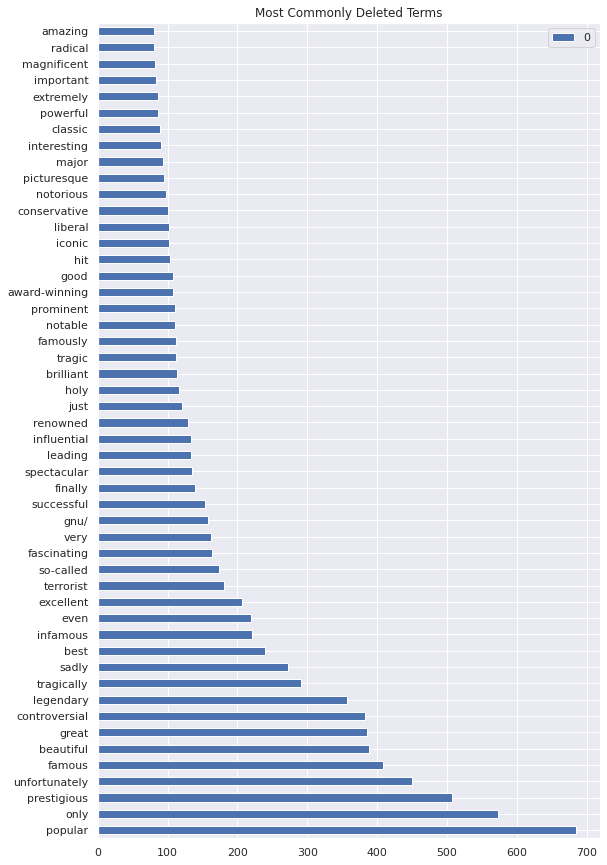

In [69]:
deleted_term_counts[:50].plot(
    kind="barh", figsize=(9, 15), title="Most Commonly Deleted Terms"
)

#### c. Commonly replaced words

In [70]:
replaced = []

for split in wnc_data_mod.keys():
    replaced.extend(
        [
            term[0][0]
            for term in wnc_data_mod[split].to_pandas().replaced
            if len(term) != 0
        ]
    )

replaced_term_counts = pd.DataFrame(
    pd.Series(replaced).value_counts().sort_values(ascending=False)
)

<AxesSubplot:title={'center':'Most Commonly Replaced Terms'}>

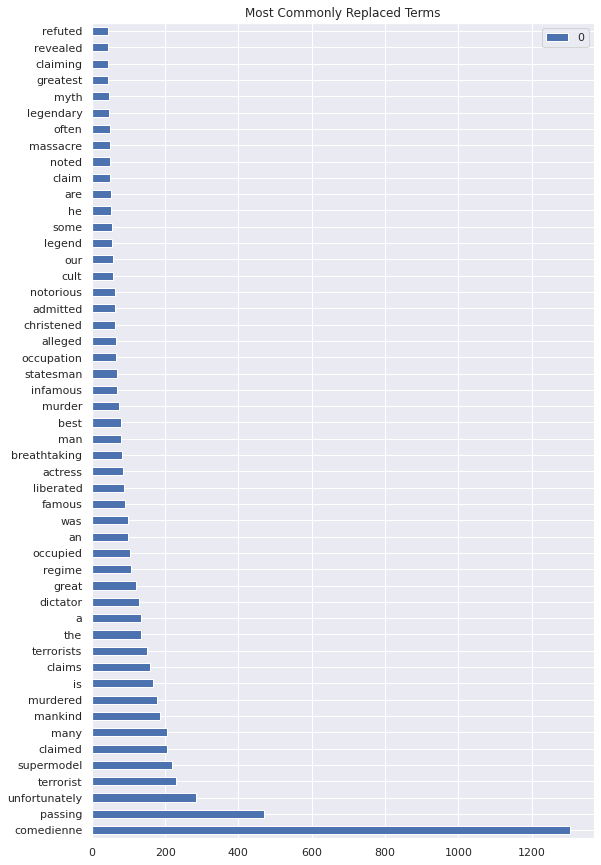

In [71]:
replaced_term_counts[:50].plot(
    kind="barh", figsize=(9, 15), title="Most Commonly Replaced Terms"
)

#### d. Commonly replaced target words

In [72]:
replaced_target = []

for split in wnc_data_mod.keys():
    replaced_target.extend(
        [
            term[0][1]
            for term in wnc_data_mod[split].to_pandas().replaced
            if len(term) != 0
        ]
    )

replaced_target_term_counts = pd.DataFrame(
    pd.Series(replaced_target).value_counts().sort_values(ascending=False)
)

<AxesSubplot:title={'center':'Most Commonly Replaced Target Terms'}>

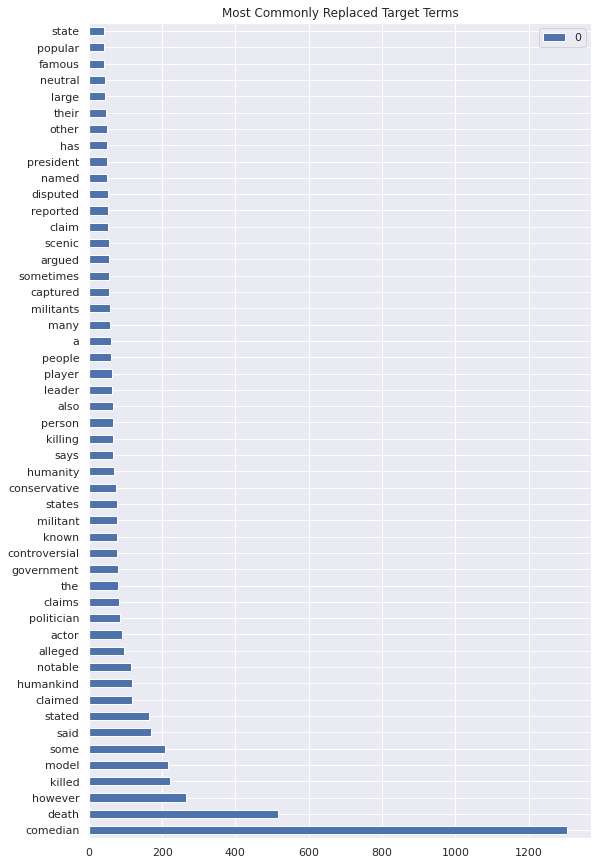

In [73]:
replaced_target_term_counts[:50].plot(
    kind="barh", figsize=(9, 15), title="Most Commonly Replaced Target Terms"
)

#### e. Commonly replaced pairs

In [74]:
replaced_pair = []

for split in wnc_data_mod.keys():
    replaced_pair.extend(
        [
            tuple(term[0])
            for term in wnc_data_mod[split].to_pandas().replaced
            if len(term) != 0
        ]
    )

In [75]:
%%time

replaced_pair_term_counts = pd.DataFrame(
    pd.Series(replaced_pair).value_counts()
)

CPU times: user 38.6 ms, sys: 2.09 ms, total: 40.7 ms
Wall time: 38.9 ms


<AxesSubplot:title={'center':'Most Commonly Replaced Pairs'}>

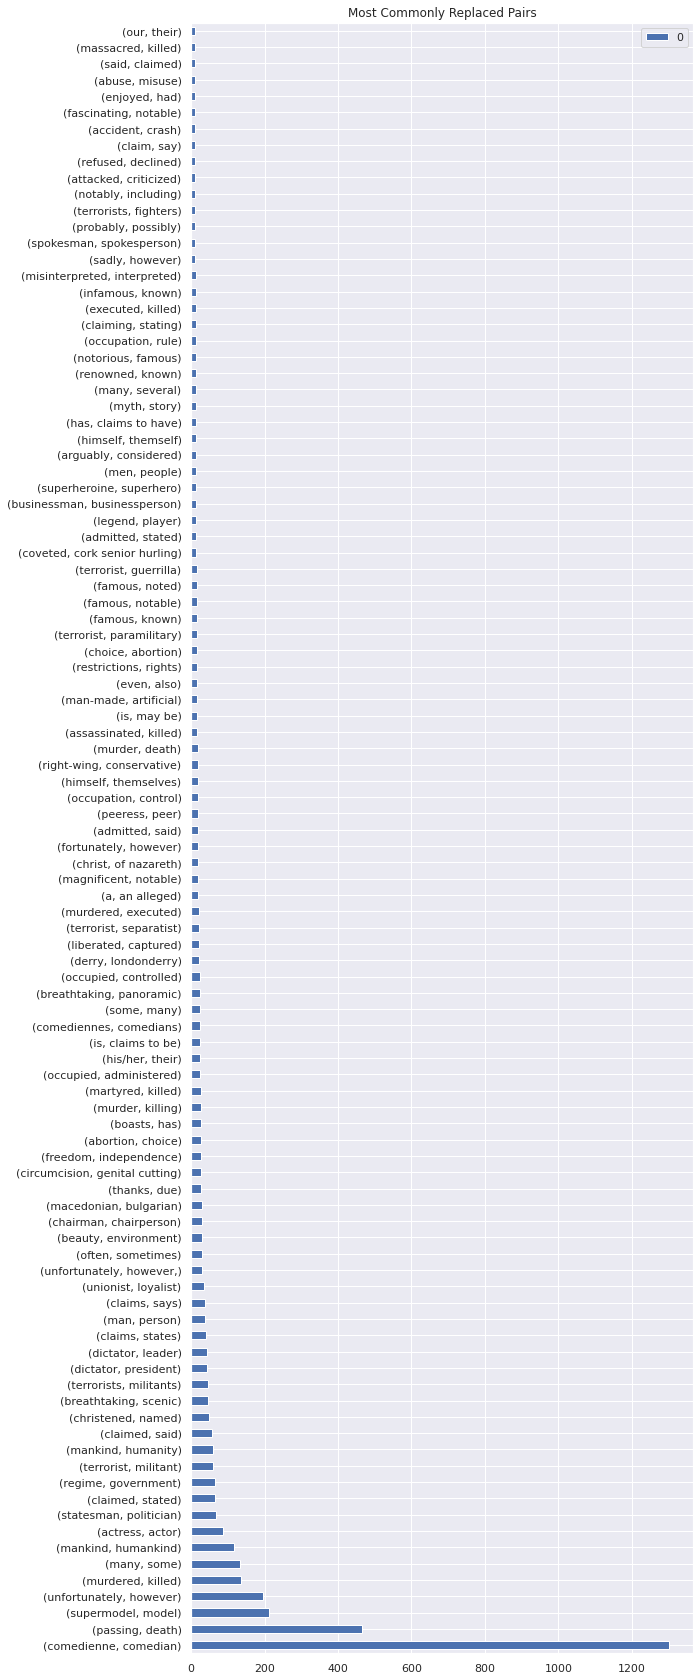

In [76]:
replaced_pair_term_counts[:100].plot(
    kind="barh", figsize=(9, 30), title="Most Commonly Replaced Pairs"
)

**Observations:**
- selection bias seems to be strong here... what were the topics/categories that these articles were pulled from? For example:
  - commedienne --> comedian
  - macedonian --> bulgarian
  - supermodel --> model
  
> "We use the Wikimedia Foundation’s categorization models (Asthana and Halfaker 2018) to bucket articles
from WNC into a 44-category ontology,3
then compare the
proportions of NPOV-driven edits across categories. Subjectively biased edits are most prevalent in history, politics,
philosophy, sports, and language categories. They are least
prevalent in the meteorology, science, landforms, broadcasting, and arts categories. This suggests that there is a relationship between a text’s topic and the realization of bias. We use
this observation to guide our model design in Section 3.1."

## Explore the Full dataset

In [18]:
DATA_PATH = "/home/cdsw/data/raw/bias_data/WNC/biased.full"

collect = []

for i, line in enumerate(tqdm(open(DATA_PATH))):
    parts = line.strip().split("\t")
    collect.append(parts)
    if i == 5:
        break

for rev in collect:
    print("REV_ID: ", rev[0])
    print()
    #     print("PRE-TOKEN: ", rev[1])
    #     print("POST-TOKEN: ", rev[2])
    #     print()
    print("PRE: ", rev[3])
    print("POST: ", rev[4])
    #     print()
    #     print()
    #     print("POS: ", rev[5])
    #     print("RELATIONS: ", rev[6])
    print(
        "------------------------------------------------------------------------------------------"
    )

5it [00:00, 8395.32it/s]

REV_ID:  258378316

PRE:  during the campaign, controversy erupted over alleged differences between palin's positions as a gubernatorial candidate and her position as a vice-presidential candidate.
POST:  during the campaign, some pointed out alleged differences between palin's positions as a gubernatorial candidate and her position as a vice-presidential candidate.
------------------------------------------------------------------------------------------
REV_ID:  486527143

PRE:  nicaea was convoked by the emperor constantine in mayaugust 325 to address the arian heresy that christ is of a distinct substance from the father.
POST:  nicaea was convoked by the emperor constantine in mayaugust 325 to address the arian position that christ is of a distinct substance from the father.
------------------------------------------------------------------------------------------
REV_ID:  54024499

PRE:  it was rather unfortunate that he vehemently opposed the budding indian scientist subrahmanya

In [19]:
DATA_PATH = "/home/cdsw/data/raw/bias_data/WNC"

wnc_datasets_full = build_hf_dataset(DATA_PATH, one_word=False)

181496it [00:03, 51900.49it/s]


In [20]:
def create_dataset_splits(wnc_datasets_full: DatasetDict):
    """
    Provided a DatasetDict containing one key for the full WNC datasets, this
    function breaks the full dataset into three splits train, dev, test.

    """
    # split 90% train / 10% test
    wnc_datasets_full = wnc_datasets_full["full"].train_test_split(
        train_size=0.9, shuffle=True, seed=42
    )

    # split 10% into 5% dev / 5% test
    train_test_temp = wnc_datasets_full["test"].train_test_split(
        train_size=0.5, shuffle=True, seed=42
    )

    # cleanup and curate DatsetDict object
    wnc_datasets_full.pop("test")
    wnc_datasets_full["test"] = train_test_temp["test"]
    wnc_datasets_full["dev"] = train_test_temp["train"]
    del train_test_temp

    return wnc_datasets_full

In [21]:
wnc_datasets_full = create_dataset_splits(wnc_datasets_full)

In [22]:
wnc_datasets_full

DatasetDict({
    train: Dataset({
        features: ['rev_id', 'translation'],
        num_rows: 163346
    })
    test: Dataset({
        features: ['rev_id', 'translation'],
        num_rows: 9075
    })
    dev: Dataset({
        features: ['rev_id', 'translation'],
        num_rows: 9075
    })
})

### Duplicates

#### Duplicates by rev_id

In [25]:
import pandas as pd

In [23]:
rev_ids = reduce(
    concat, [wnc_datasets_full[split]["rev_id"] for split in wnc_datasets_full.keys()]
)

print(f"Looks like there are {len(rev_ids) - len(set(rev_ids))} duplicates")

Looks like there are 2350 duplicates


In [26]:
rev_ids_pd = pd.Series(rev_ids)
duplicate_revids = rev_ids_pd[rev_ids_pd.duplicated()].tolist()

In [28]:
len(duplicate_revids)

2350

In [29]:
duplicate_dataset = wnc_datasets_full.filter(lambda x: x["rev_id"] in duplicate_revids)

  0%|          | 0/164 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [30]:
duplicate_dataset

DatasetDict({
    train: Dataset({
        features: ['rev_id', 'translation'],
        num_rows: 4118
    })
    test: Dataset({
        features: ['rev_id', 'translation'],
        num_rows: 240
    })
    dev: Dataset({
        features: ['rev_id', 'translation'],
        num_rows: 213
    })
})

In [34]:
## inspect duplicates
duplicates_df = duplicate_dataset["train"].to_pandas()

inspect_df(duplicates_df)

15266461

278
ideas of social mobility figure prominently in the american dream, which holds that someone born into a poor family can, through hard work, ultimately rise into the upper classes.
nevertheless, ideas of social mobility figure prominently in the american dream, which holds that someone born into a poor family can, through hard work, ultimately rise into the upper classes.

1123
the social structure of the united states is somewhat stratified, with a significant class of very wealthy individuals, who hold a disproportionate amount of economic capital .
the social structure of the united states is somewhat stratified, with a significant class of very wealthy individuals, who are often alleged to hold disproportionate cultural and political influence .

-------------------------------

2213485

3174
this is one of the primary reasons the marlins have been pushing for a stadium of their own.
this is thought to be one of the primary reasons the marlins have been pushing for a s

**Observation:**
- There are way more duplicates (2350) by revision_id in the full dataset. These duplicates do occur across splits.
- We'll drop them all.

#### Duplicates by text

In [36]:
translations = reduce(
    concat,
    [wnc_datasets_full[split]["translation"] for split in wnc_datasets_full.keys()],
)
translations = [
    tuple(translation.items()) for translation in translations
]  # make tuples so hashable

print(f"Looks like there are {len(translations) - len(set(translations))} duplicates")

Looks like there are 0 duplicates


In [37]:
# dropping duplicates by rev_id
wnc_datasets_full = remove_duplicate_by_revid(wnc_datasets_full)

4700 duplicate records have been removed.


  0%|          | 0/164 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [39]:
wnc_datasets_full

DatasetDict({
    train: Dataset({
        features: ['rev_id', 'translation'],
        num_rows: 159228
    })
    test: Dataset({
        features: ['rev_id', 'translation'],
        num_rows: 8835
    })
    dev: Dataset({
        features: ['rev_id', 'translation'],
        num_rows: 8862
    })
})

### Descriptive Stats

In [40]:
# create new dataset with calculated column lengths
wnc_datasets_full_mod = wnc_datasets_full.map(
    lambda example: {
        "length_pre": len(example["translation"]["pre"].split()),
        "length_post": len(example["translation"]["post"].split()),
    }
)

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

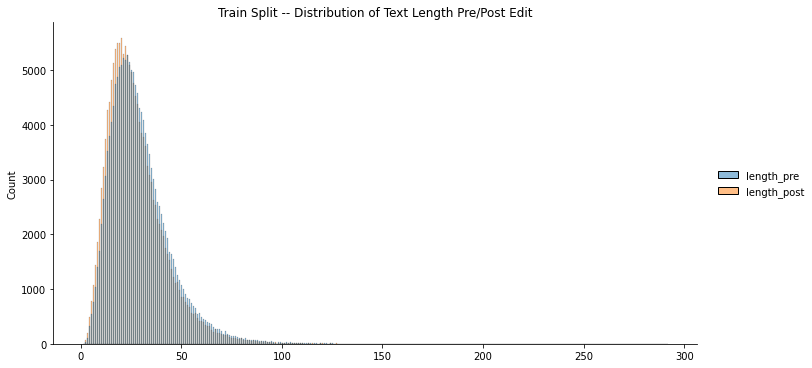

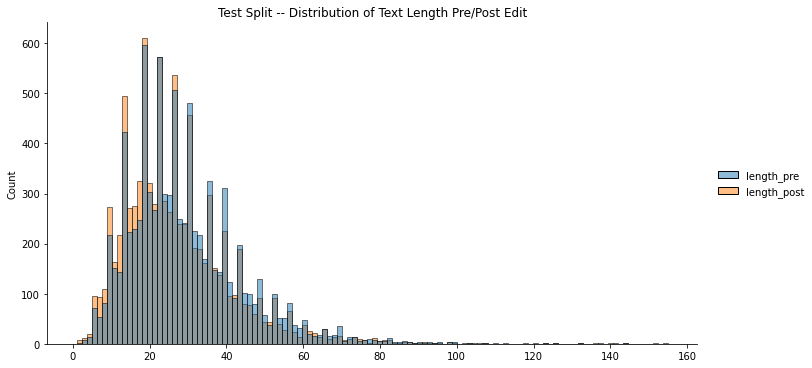

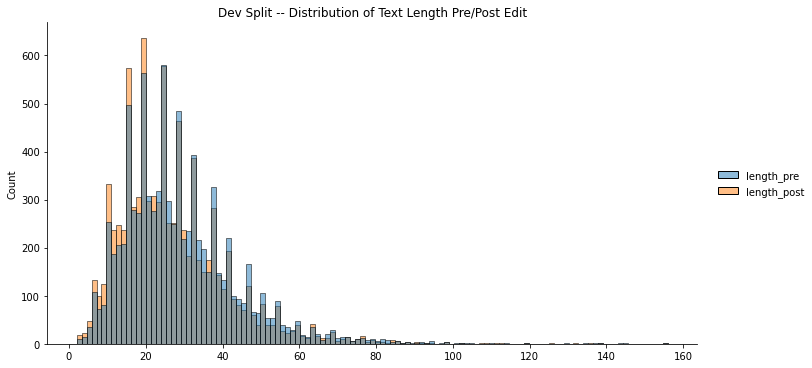

In [43]:
for split in wnc_datasets_full_mod.keys():
    test_df = wnc_datasets_full_mod[split].to_pandas()
    sns.displot(test_df[["length_pre", "length_post"]], kind="hist", aspect=2).set(
        title=f"{split.capitalize()} Split -- Distribution of Text Length Pre/Post Edit"
    )

In [44]:
# collect descriptive statistics for each split
stats = {}
for split in wnc_datasets_full_mod.keys():
    test_df = wnc_datasets_full_mod[split].to_pandas()
    stat = test_df[["length_pre", "length_post"]].describe().round(2)
    stats[split] = stat

# format as dataframe
pd.concat(stats).unstack(0).swaplevel(0, 1, axis=1).sort_index(axis=1)

dev                   test                  train           
      length_post length_pre length_post length_pre length_post length_pre
count     8862.00    8862.00     8835.00    8835.00   159228.00  159228.00
mean        27.00      28.83       27.11      29.10       27.32      29.23
std         14.28      14.76       14.36      14.94       14.71      15.27
min          2.00       2.00        1.00       2.00        1.00       2.00
25%         17.00      18.00       17.00      19.00       17.00      19.00
50%         24.00      26.00       24.00      26.00       24.00      26.00
75%         34.00      36.00       34.00      37.00       34.00      37.00
max        156.00     156.00      152.00     155.00      287.00     292.00

In [45]:
# calculate the change in text length after making revision
wnc_datasets_full_mod = wnc_datasets_full_mod.map(
    lambda example: {"delta": example["length_post"] - example["length_pre"]}
)

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

<AxesSubplot:title={'center':'Percentage of Edits by Change in Word Count (by Split)'}, xlabel='delta'>

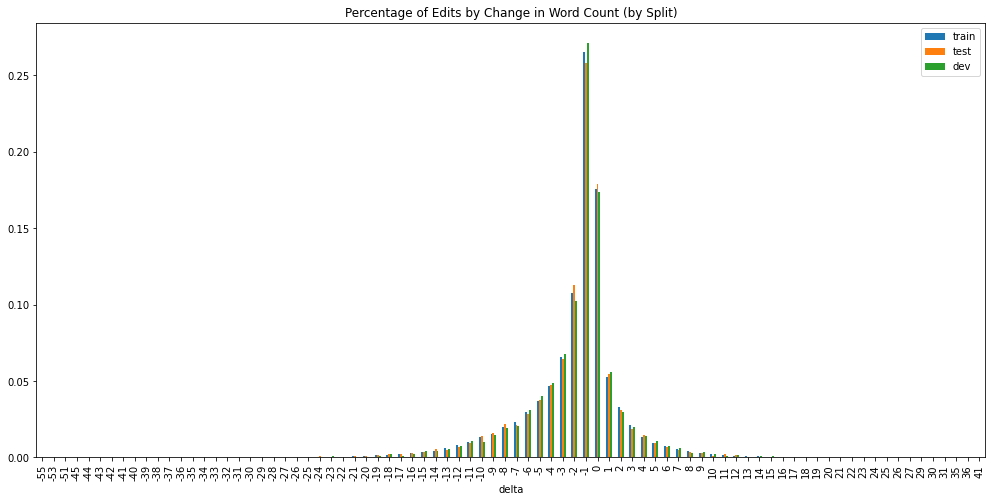

In [46]:
# aggregate number of revision by the change in length
deltas = {}
for split in wnc_datasets_full_mod.keys():
    delta = (
        wnc_datasets_full_mod[split]
        .to_pandas()[["rev_id", "delta"]]
        .groupby("delta")
        .count()
    )
    deltas[split] = delta

# format for plotting
delta_df = pd.concat(deltas).unstack(0).droplevel(0, axis=1).fillna(0)

for col in delta_df.columns:
    delta_df[col] = delta_df[col] / delta_df[col].sum()


delta_df.plot.bar(
    title="Percentage of Edits by Change in Word Count (by Split)", figsize=(17, 8)
)

### Investigate rare additive and subtractive examples

In [48]:
rare_subtractive = wnc_datasets_full_mod.filter(
    lambda example: example["delta"] in [-55, -53, -45]
)

  0%|          | 0/160 [00:00<?, ?ba/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

In [53]:
rare_subtractive["train"][1]

{'rev_id': '374556801',
 'translation': {'post': "the main causes of this claim is the idea promoted by sindhi nationalists that water resources are diverted disproportionately to the punjab region at sindh's expense, particularly the water from the kalabagh dam and thal canal, which divert water resources away from sindh; this allegation was dismissed by domestic and international experts,especially as pakistan government had already banned the construction of the kalabagh dam on the insistence of sindh government.the movement is heavily criticized for only concentrating on blaming the punjabis for sindh's ills such as trying to lay all blame on sindh's water shortage on punjab,instead of the sindhi politicians who have shelved several plans to develop the rich water resources that sindh has been endowed with,particularly lower sindh.",
  'pre': "the main causes of this claim is the idea promoted by sindhi nationalists that water resources are diverted disproportionately to the punjab

### Diffs

In [76]:
random_sample_full = wnc_datasets_full_mod["full"].shuffle(seed=42).select(range(25))

In [77]:
for i, row in random_sample_full.to_pandas().iterrows():
    print("PRE: ", row["translation"]["pre"])
    print("POST: ", row["translation"]["post"])

    print(get_diff(s1=row["translation"]["pre"], s2=row["translation"]["post"]))
    print()
    print("------------------------------")

PRE:  alternatively, it can be used directly with the perl module ~drrho /tm -1.26 / tm (which also supports ltm).
POST:  alternatively, it can be used directly with the perl module dist /tm/ tm (which also supports ltm).
{'deleted': [], 'replaced': [('~drrho /tm -1.26 /', 'dist /tm/')]}

------------------------------
PRE:  however, no evidence of his presence was found by freedom fighters when they captured the compound, nor was their evidence of a presence (or previous presence) of any of his sons.
POST:  however, no evidence of his presence was found by rebels when they captured the compound, nor was their evidence of a presence (or previous presence) of any of his sons.
{'deleted': [], 'replaced': [('freedom fighters', 'rebels')]}

------------------------------
PRE:  it is home to the world's largest jewish studies library, and some of the world's most eminent scholars have been faculty members , among them gershom scholem, yeshayahu leibowitz, daniel kahneman and robert aumann.


**Idea:**
- New evaluation criteria we could look into: since this type of style transfer is largely about replacement of subjective words/phrasese to objective ones --> we could have a metric that checks: "did the subjective part of the sentence get altered?"
- Basically, did the right words get targeted for replacement?

## Concerns
1. WNC "one word" version may not be good use case for TST. It can likely be solved better/simpler with other NLP methods like detecting subjective words and removing/replacing.
2. If so, we would need to begin working with the full WNC dataset...sooner rather than later.
3. NPOV rules currently define our definition of "subjectivity". It appears these rules may include edits that introduce additional factual context to a sentence as a means to make it more neutral (as not to conceal relevant information). If this is true, even the full dataset is not a good use case for TST as this places the expectation that a model can introduce factual information on any given subject.
    - I doesn't seem there are a of these at first glance. And even if there are, I think we can account for this by removing largely additive examples from our dataset!


## Next Steps

### Write preprocessing script:
From all the information gathered here, let's preprocess the raw dataset to:
1. remove duplicate records
2. remove records where the pre or post revision text is >100(?) tokens or <3 tokens
3. remove rare subtractive records (those where lots of spaces were removed as thats non-NPOV)
4. remove rare additive records (those where additional context was actually added as thats also non-NPOV)

### Model and evaluate one-word version
- Develop a baseline seq2seq model
- Evaluate it with standard procedure
- Compare performance to:
    a. the paper benchmarks
    b. a naive method where we simply use a lexicon lookup of commonly subjective words and just delete them
    
### Extend modeling process to full dataset
- Preprocess full dataset to remove troublesome examples
- Repurpose training setup and test harness
- Evaluate and analyze errors